# The Adult Data Set

This notebook explores the *adult* data set via Spark ML.  The core objective is to **predict whether an individual's income exceeds $50K/year based on census data**.



<br>

## Preliminaries


### Java

Setting-up via Python, after updating `JAVA`


> import os

> os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-1.8.0-openjdk-amd64'

<br>

Selecting a `JAVA` version


> !update-alternatives --config java



<br>


<br>

Update `JAVA`

In [ ]:
%%bash
apt purge *java &> java.log
apt-get install openjdk-8-jdk &>> java.log
update-java-alternatives --list &>> java.log

<br>

The `JAVA` version

In [ ]:
!java -version

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


<br>
<br>

### Spark Environment Variables

Packages

In [ ]:
!pip install pyspark &> pyspark.log
!pip install py4j &> py4j.log

<br>

Spark Session

> from pyspark.sql import SparkSession

In [ ]:
import pyspark.sql

In [ ]:
SparkSession = pyspark.sql.SparkSession
spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

<br>

Spark Logging Level

In [ ]:
spark.sparkContext.setLogLevel('WARN')

<br>
<br>

### Logging

> logging.basicConfig(level=logging.WARN)

In [ ]:
import logging

In [ ]:
logging.disable(logging.WARN)
logger = logging.getLogger(__name__)

<br>
<br>

### Libraries


Standard

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
sns.set_context("poster")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<br>

And

In [ ]:
import pyspark

from pyspark.sql.types import Row
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import when, col, mean, desc, round, lower, count, avg, sum

from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.classification import RandomForestClassifier


<br>
<br>

### Classes, Functions, Methods

Data retrieval via query language 

In [ ]:
import src.functions.sql

In [ ]:
qlr = src.functions.sql.SQL(spark=spark)

<br>

Default tables

In [ ]:
defaults = qlr.query('show tables')

In [ ]:
defaults

DataFrame[database: string, tableName: string, isTemporary: boolean]

In [ ]:
defaults.toPandas()

,database,tableName,isTemporary


<br>

Cleaning-up

In [ ]:
qlr.query('drop table if exists adult')

DataFrame[]

<br>
<br>

## Loading the Dataset

Below we will use Spark SQL to load in the data and then register it as a Dataframe. So the end result will be a Spark SQL table called `adult` and a Spark Dataframe called `adult_df`.

<br>
<br>

### Data Download

In [ ]:
adult = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQEAgYxP1ViLp_WLEVQpbXiL0SJX_lafVKvKJGbjjyBhxi1sYVWmajEuGp9ydgUKksoBq0R0r-5-can/pub?output=csv', header=None)
adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [ ]:
adult.to_csv('adult.csv', index=False, header=False)
del adult
!ls

adult.csv  sample_data	spark-warehouse


<br>
<br>

### Creating the DataFrame

In this section, a spark dataframe of the `adult` dataset is created.

In [ ]:
# File location and type
file_location_adult = "adult.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# The schema based on the data set dictionary
# at: https://archive.ics.uci.edu/ml/datasets/adult
schema = StructType([
      StructField('age', DoubleType()),
      StructField('workclass', StringType()),
      StructField('fnlwgt', DoubleType()),
      StructField('education', StringType()),
      StructField('education_num', DoubleType()),
      StructField('marital_status', StringType()),
      StructField('occupation', StringType()),
      StructField('relationship', StringType()),
      StructField('race', StringType()),
      StructField('sex', StringType()),
      StructField('capital_gain', DoubleType()),
      StructField('capital_loss', DoubleType()),
      StructField('hours_per_week', DoubleType()),
      StructField('native_country', StringType()),
      StructField('income', StringType())
])


# The applied options are for CSV files
adult_df = (spark.read.format(file_type) 
                    .schema(schema)
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_location_adult))

In [ ]:
type(adult_df)

pyspark.sql.dataframe.DataFrame

<br>
<br>

### Viewing the DataFrame Schema

The schema of the dataset

In [ ]:
print('Adult Dataset Schema')
adult_df.printSchema()

Adult Dataset Schema
root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [ ]:
adult_df.registerTempTable("adult")
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,adult,True


<br>
<br>

### Viewing the Dataset

<br>

**All fields**

In [ ]:
df = run_sql("SELECT * FROM adult LIMIT 5")
df.toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


<br>
<br>

**Grouped by occupation**

In [ ]:
occupations = run_sql(
  """
  SELECT 
    occupation,
    sum(age) as n,
    round( avg( if(lower(marital_status) LIKE 'married-%', 1, 0) ), 2) as married_rate,
    round( avg( if(lower(marital_status) LIKE '%widow%', 1, 0)), 2) as widow_rate,
    round( avg( if(lower(marital_status) = 'divorced', 1, 0)), 2) as divorce_rate,
    round( avg( if(lower(marital_status) = 'separated', 1, 0)), 2) as separated_rate,
    round( avg( if(lower(marital_status) = 'never-married', 1, 0)), 2) as bachelor_rate
  FROM 
    adult 
  GROUP BY occupation
  ORDER BY n DESC
  """)
type(occupations)

pyspark.sql.dataframe.DataFrame

In [ ]:
occupations.limit(100).toPandas()

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Exec-managerial,171460.0,0.61,0.02,0.15,0.02,0.20
1,Prof-specialty,167743.0,0.53,0.02,0.13,0.02,0.30
2,Craft-repair,159990.0,0.64,0.01,0.11,0.03,0.21
3,Adm-clerical,139356.0,0.28,0.04,0.22,0.04,0.42
4,Sales,136342.0,0.47,0.03,0.12,0.03,0.36
5,Other-service,115159.0,0.24,0.05,0.15,0.06,0.50
6,Machine-op-inspct,75506.0,0.51,0.03,0.14,0.04,0.29
7,?,75347.0,0.36,0.08,0.10,0.04,0.42
8,Transport-moving,64196.0,0.63,0.02,0.11,0.02,0.21
9,Handlers-cleaners,44067.0,0.36,0.01,0.09,0.03,0.51


<br>

DataFrame registration

In [ ]:
# Herein the 'occupations' dataframe is registered so that
# it can be queried via Spark SQL also.
occupations.registerTempTable('occupations')
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,adult,True
1,,occupations,True


<br>

Querying the registered dataframe via Spark SQL

In [ ]:
run_sql("SELECT * FROM occupations").limit(5).toPandas()

,occupation,n,married_rate,widow_rate,divorce_rate,separated_rate,bachelor_rate
0,Exec-managerial,171460.0,0.61,0.02,0.15,0.02,0.20
1,Prof-specialty,167743.0,0.53,0.02,0.13,0.02,0.30
2,Craft-repair,159990.0,0.64,0.01,0.11,0.03,0.21
3,Adm-clerical,139356.0,0.28,0.04,0.22,0.04,0.42
4,Sales,136342.0,0.47,0.03,0.12,0.03,0.36


<br>
<br>

### Q1


Spark SQL: The top 'bachelor_rate' by 'education'

In [ ]:
# Q1

education = run_sql(
  """
  SELECT 
    lower(education) as education,    
    round( avg( if(lower(marital_status) = 'never-married', 1, 0)), 2) as bachelor_rate
  FROM 
    adult 
  GROUP BY lower(education)
  ORDER BY bachelor_rate DESC
  
  """)
education.registerTempTable('education')
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,adult,True
1,,education,True
2,,occupations,True


In [ ]:
# Either
# education.limit(100).toPandas()

# Or
run_sql('select * from education').limit(100).toPandas()

,education,bachelor_rate
0,12th,0.54
1,11th,0.50
2,preschool,0.43
3,some-college,0.40
4,10th,0.39
5,bachelors,0.34
6,assoc-acdm,0.32
7,9th,0.30
8,hs-grad,0.29
9,5th-6th,0.27


<br>
<br>

## Spark DataFrames

<br>

Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [ ]:
del adult_df
adult_df = spark.table('adult')
cols = adult_df.columns

In [ ]:
print(type(adult_df))
print(adult_df.printSchema())
print(cols)

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)

None
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


<br>
<br>

`toPandas()` dumps an entire spark dataframe (which might be distributed) in a local system, which might crash a notebook if resources are inadequate. A good - and almost always required - approach is to use `limit()` to limit the number of records to view.

In [ ]:
adult_df.limit(5).toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


<br>
<br>

### Using the DataFrame API for computations

Divorce rate by occupation

In [ ]:
divorced = adult_df.select(
  adult_df['occupation'], 
  when( lower(col('marital_status')) == 'divorced' , 1 ).otherwise(0).alias('is_divorced')
)
divorced = divorced.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
divorced = divorced.orderBy(desc('divorced_rate'))
divorced.limit(100).toPandas()

,occupation,divorced_rate
0,Adm-clerical,0.22
1,Priv-house-serv,0.19
2,Tech-support,0.15
3,Other-service,0.15
4,Exec-managerial,0.15
5,Machine-op-inspct,0.14
6,Prof-specialty,0.13
7,Protective-serv,0.12
8,Sales,0.12
9,Transport-moving,0.11


<br>
<br>

### Q2

The top 'bachelor_rate' by 'education'; using the DataFrame API

In [ ]:
# Q2

bachelor = adult_df.select( lower(adult_df['education']).alias('education'),
                when( lower(col('marital_status')) == 'never-married' , 1 ).otherwise(0).alias('bachelor')
                )
bachelor = bachelor.groupBy('education').agg( round(mean('bachelor'), 2).alias('bachelor_rate'))
bachelor = bachelor.orderBy(desc('bachelor_rate'))
bachelor.limit(100).toPandas()

,education,bachelor_rate
0,12th,0.54
1,11th,0.50
2,preschool,0.43
3,some-college,0.40
4,10th,0.39
5,bachelors,0.34
6,assoc-acdm,0.32
7,9th,0.30
8,hs-grad,0.29
9,5th-6th,0.27


<br>
<br>


## Explore & Visualize Data

It's very easy to convert a Spark DataFrame into a Pandas DataFrame, and subsequently analyse or plot the data in question.  There are two options


* `pandas.DataFrame(pyspark.sql.dataframe.DataFrame.limit(...).collect(), ...)`

* `pyspark.sql.dataframe.DataFrame.limit().toPandas()`

Large Pandas DataFrames are problematic, a best practice is to only collect aggregated or sampled data into a Pandas DataFrame.

<br>

In [ ]:
# High earnings by occupation
high = run_sql(
  """
  SELECT 
    occupation,
    avg( if(income = '>50K', 1, 0) ) as plus_50k
  FROM 
    adult 
  GROUP BY occupation
  ORDER BY plus_50k DESC
  """)

type(high)

pyspark.sql.dataframe.DataFrame

<br>

Via collect()

In [ ]:
pd.DataFrame(data=high.limit(100).collect(), columns=high.schema.names)

,occupation,plus_50k
0,Exec-managerial,0.484014
1,Prof-specialty,0.449034
2,Protective-serv,0.325116
3,Tech-support,0.304957
4,Sales,0.269315
5,Craft-repair,0.226641
6,Transport-moving,0.200376
7,Adm-clerical,0.134483
8,Machine-op-inspct,0.124875
9,Farming-fishing,0.115694


<br>

Via toPandas()

In [ ]:
summary = high.limit(100).toPandas()
summary.head()

,occupation,plus_50k
0,Exec-managerial,0.484014
1,Prof-specialty,0.449034
2,Protective-serv,0.325116
3,Tech-support,0.304957
4,Sales,0.269315


In [ ]:
summary.describe()

,plus_50k
count,15.000000
mean,0.197354
std,0.143994
min,0.006711
25%,0.107373
50%,0.134483
75%,0.287136
max,0.484014


In [ ]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
occupation    15 non-null object
plus_50k      15 non-null float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes


<br>
<br>

Plotting

<Figure size 432x432 with 0 Axes>

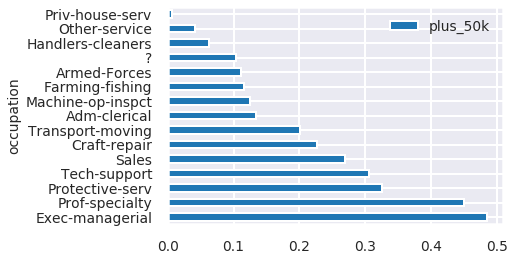

In [ ]:
plt.figure(figsize=(6, 6), frameon=False, edgecolor=None)
summary.plot(kind='barh', x='occupation', y='plus_50k')
plt.tick_params(axis='both', labelsize='xx-small')
plt.ylabel('occupation', fontsize='xx-small')
plt.legend(loc='upper right', frameon=False, fontsize='xx-small')

<br>
<br>

Statistics

A few statistics and mathematics tools are summarised at [Statistical & Mathematical Functions with DataFrames in Spark](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html).  **Important**, apply functions and methods to the appropriate objects.

In [ ]:
type(adult_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
type(summary)

pandas.core.frame.DataFrame

In [ ]:
# Describing data via Pandas

# The number of records in the table 'adult'
# N = run_sql('select count(*) as nrecords from adult').limit(1).collect()[0]['nrecords']
N = adult_df.count()

# Hence, a description of two features of the 'adult' table
adult_df.select(adult_df['age'], adult_df['education_num']).limit(N).toPandas().describe()

,age,education_num
count,32561.000000,32561.000000
mean,38.581647,10.080679
std,13.640433,2.572720
min,17.000000,1.000000
25%,28.000000,9.000000
50%,37.000000,10.000000
75%,48.000000,12.000000
max,90.000000,16.000000


<br>
<br>

## ML Pipeline


### What is MLlib?

MLlib is Spark’s machine learning (ML) library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:


- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

<br>

Notes:

* **The MLlib RDD-based API is now in maintenance mode.**
As of Spark 2.0, the RDD-based APIs in the `spark.mllib` package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the `spark.ml` package.

* **Why is MLlib switching to the DataFrame-based API?**
DataFrames provide a more user-friendly API than RDDs. The many benefits of DataFrames include Spark Datasources, SQL/DataFrame queries, Tungsten and Catalyst optimizations, and uniform APIs across languages.
The DataFrame-based API for MLlib provides a uniform API across ML algorithms and across multiple languages.
DataFrames facilitate practical ML Pipelines, particularly feature transformations. See the Pipelines guide for details.

* **What is “Spark ML”?**
“Spark ML” is not an official name but occasionally used to refer to the MLlib DataFrame-based API. This is majorly due to the org.apache.spark.ml Scala package name used by the DataFrame-based API, and the “Spark ML Pipelines” term we used initially to emphasize the pipeline concept.

* **Is MLlib deprecated?**
No. MLlib includes both the RDD-based API and the DataFrame-based API. The RDD-based API is now in maintenance mode. But neither API is deprecated, nor MLlib as a whole.

<br>

<br>
<br>

### Data Preparation

In [ ]:
def distinct_text(frame: pyspark.sql.dataframe.DataFrame, feature: str):
  return frame.select(lower(frame[feature]).alias(feature)).distinct()

In [ ]:
distinct_text(adult_df, 'marital_status').show()

+--------------------+
|      marital_status|
+--------------------+
|           separated|
|       never-married|
|            divorced|
|   married-af-spouse|
|             widowed|
|  married-civ-spouse|
|married-spouse-ab...|
+--------------------+



<br>

Categorical Features

In [ ]:
# Categorical
categoricalColumns = ["workclass", "education", "marital_status", "occupation", 
                      "relationship", "race", "sex", "native_country"]

# Pipeline Stages
stages = [] 

for categoricalCol in categoricalColumns:

    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")

    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

<br>

The Target

In [ ]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

<br>

Assembling

In [ ]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

<br>

Create Pipeline

In [ ]:
# Stages
pipeline = Pipeline(stages=stages)

In [ ]:
# fit()
pipelineModel = pipeline.fit(adult_df)

In [ ]:
# transform()
dataset = pipelineModel.transform(adult_df)

In [ ]:
print('\n')

# Relevant Columns
print(cols)

selectedcols = ["label", "features"] + cols
print(selectedcols)

dataset = dataset.select(selectedcols)
print('\n')
dataset.limit(5).toPandas()



['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
['label', 'features', 'age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']




,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


<br>

Splitting

In [ ]:
# Randomly split the data into training and test sets. 
# Set seed for reproducibility.
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22838
9723


<br>

Positive Rate

In [ ]:
# Get the positive outcome rate from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0]
print("Positive rate in the training data is {:.9f}".format(training_data_positive_rate))

Positive rate in the training data is 0.239337946


<br>
<br>


## Logistic Regression

### Training

In [ ]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Set the threshold probability; above this value the prediction is 1
# In the case of a balanced data set, lr.setThreshold(0.5)
lr.setThreshold(training_data_positive_rate)

# Train the model using the training data
lrModel = lr.fit(trainingData)

In [ ]:
# Training summary: evaluation metrics, etc.
# Study lrTrainingSummary...
lrTrainingSummary = lrModel.summary

<br>

Find the best model threshold via F-Measure; this can be used in-place-of of the empirical threshold above, i.e., instead of `training_data_positive_rate`

In [ ]:
fMeasure = lrTrainingSummary.fMeasureByThreshold
fMeasure.show()

+------------------+-------------------+
|         threshold|          F-Measure|
+------------------+-------------------+
|0.9881789774376804|0.07938180540920269|
|0.9522596232935533|0.15096251266464034|
|0.9128821906475122|0.21333333333333332|
|0.8783568138482458|0.26842270304170585|
| 0.846832504981947| 0.3181955797759612|
|0.8197598874826746|   0.36318407960199|
|0.7936590401209885|0.40413480600396484|
|0.7675198419482364|0.44005486968449925|
|0.7407496558430026| 0.4722000532056398|
|0.7176989006934128| 0.5019364833462432|
|0.6930691876666157| 0.5282167042889391|
|0.6694522228757335| 0.5491343574737869|
|0.6465244034563071| 0.5686832740213523|
|0.6233901143828772| 0.5902055902055902|
|0.6014494446349671| 0.6036461850101282|
|0.5789524502571417| 0.6197059468948869|
|0.5578027177842299| 0.6339113680154143|
|0.5359313569334495| 0.6430512016718913|
|0.5142971230309104| 0.6505409267197386|
|0.4947275202645046| 0.6584879313784161|
+------------------+-------------------+
only showing top

<br>

**Original Approach**

The best threshold w.r.t. maximum F-Measure

In [ ]:
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# lrBestThreshold = (fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)'])
#                            .select('threshold').head()['threshold'])
  
# print("Best threshold based on model performance on training data is {:.9f}".format(lrBestThreshold))

<br>

**Alternative Approach**

In [ ]:
maxFMeasure = fMeasure.agg({'F-Measure': 'max'}).collect()[0][0]
lrBestThreshold = fMeasure.filter( fMeasure['F-Measure'] == maxFMeasure ).collect()[0]['threshold']

f"Best threshold based on model performance on training data is {lrBestThreshold:.9f}"

'Best threshold based on model performance on training data is 0.333456401'

<br>
<br>

### Predictions

Re-build.

In [ ]:
# Check current model prediction threshold
print(training_data_positive_rate)
lrModel._java_obj.getThreshold()

0.23933794552938087


0.23933794552938087

In [ ]:
# Rebuild the model using the optimal threshold of the training stage
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Set the threshold probability; above this value the prediction is 1
lr.setThreshold(lrBestThreshold)

# Train the model using the training data
lrModel = lr.fit(trainingData)

print(lrBestThreshold)
lrModel._java_obj.getThreshold()

0.3334564005935537


0.3334564005935537

<br>

Hence, predictions.

In [ ]:
# Make predictions via the test data
lrPredictions = lrModel.transform(testData)

# Display predictions
lrPredictions.select("label", "prediction", "probability").limit(10).toPandas()

,label,prediction,probability
0,0.0,0.0,"[0.6922983871168307, 0.30770161288316944]"
1,0.0,1.0,"[0.6211120976664523, 0.3788879023335478]"
2,0.0,1.0,"[0.6584122200236687, 0.3415877799763313]"
3,0.0,1.0,"[0.6582271564526575, 0.34177284354734244]"
4,0.0,1.0,"[0.615005375173587, 0.38499462482641306]"
5,0.0,1.0,"[0.5398470871555112, 0.46015291284448884]"
6,0.0,1.0,"[0.6004373110540357, 0.3995626889459642]"
7,0.0,1.0,"[0.5898543397425517, 0.41014566025744825]"
8,0.0,1.0,"[0.5824255739342137, 0.4175744260657862]"
9,0.0,1.0,"[0.5920238300589081, 0.40797616994109187]"


<br>

Just curious

In [ ]:
observations = lrPredictions.withColumn('status', lrPredictions['label'] == lrPredictions['prediction'])
matching = observations.select( when ( observations['status'] == True, 1 ).otherwise(0).alias('status') )

In [ ]:
# Either
matching.agg( round(avg('status'), 3).alias('average') ).collect()[0]['average']

0.831

In [ ]:
# Or
fraction = matching.agg( sum('status').alias('n') ).collect()[0]['n'] / matching.count()
f"{fraction:.3f}"

'0.831'

<br>
<br>

## Gradient Boosting Machines (GBM)

Here you will train your own GBM Classifier and make predictions

### Q3: Training


Train a GBTClassifier using the training data, call the trained model `gbModel`.  Note: You don't need to set a prediction threshold here, just train a vanilla GBM model.

In [ ]:
# Defaults at https://spark.apache.org/docs/2.4.4/api/python/pyspark.ml.html#module-pyspark.ml.classification

# Gradient Boosted Trees Classifier Instance
gb = GBTClassifier(labelCol='label', featuresCol='features')

# Train
gbModel = gb.fit(trainingData)

<br>
<br>

### Q4: Predictions


Get the predictions w.r.t. the test data.  Name the predictions dataframe `gbPredictions` and display the first 10 records.

In [ ]:
gbPredictions = gbModel.transform(testData)
gbPredictions.select("label", "prediction", "probability", "rawPrediction").limit(10).toPandas()

,label,prediction,probability,rawPrediction
0,0.0,0.0,"[0.812999752839707, 0.18700024716029295]","[0.7348104334855271, -0.7348104334855271]"
1,0.0,0.0,"[0.75060836443013, 0.24939163556986998]","[0.5509297679130609, -0.5509297679130609]"
2,0.0,0.0,"[0.75060836443013, 0.24939163556986998]","[0.5509297679130609, -0.5509297679130609]"
3,0.0,0.0,"[0.7375857220003627, 0.26241427799963735]","[0.5167289229911398, -0.5167289229911398]"
4,0.0,0.0,"[0.5395684793967337, 0.4604315206032663]","[0.07930278492418873, -0.07930278492418873]"
5,0.0,0.0,"[0.5426622730931254, 0.4573377269068746]","[0.08553251754252839, -0.08553251754252839]"
6,0.0,0.0,"[0.5838527646913241, 0.4161472353086759]","[0.169304853557165, -0.169304853557165]"
7,0.0,0.0,"[0.5838527646913241, 0.4161472353086759]","[0.169304853557165, -0.169304853557165]"
8,0.0,0.0,"[0.7248518597139232, 0.2751481402860768]","[0.48432882898678653, -0.48432882898678653]"
9,0.0,0.0,"[0.7248518597139232, 0.2751481402860768]","[0.48432882898678653, -0.48432882898678653]"


<br>
<br>


## Model Performance Evaluation


### Q5: Logistic Regression - Evaluation

The `print_performance_metrics()` function below has been completed to include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

**Notes**

The confusion matrix structure is

* DenseMatrix(numRows, numColumns [ CV of Label 0.0 | CV of Label 1.0, ... ] )

wherein CV denotes *column values*.  Use `pyspark.mllib.linalg.DenseMatrix().values[...]`, and numRows & numColumns, to extract data per column.

Binary Case:

* Column 1: [true negative, false negative]
* Column 2: [false positive, true positive] 



In [ ]:
def print_performance_metrics(predictions):
  
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("auc = {}".format(auc))
    print("aupr = {}".format(aupr))

    # Get RDD of predictions and labels for MLLib Evaluation Metrics
    predictionAndLabels = predictions.select("prediction","label").rdd

    # Instantiate metrics objects
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    multi_metrics = MulticlassMetrics(predictionAndLabels)

    # Area under precision-recall curve
    print("Area under PR = {}".format(binary_metrics.areaUnderPR))
    # Area under ROC curve
    print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
    # Accuracy
    print("Accuracy = {}".format(multi_metrics.accuracy))
    # Confusion Matrix
    print(multi_metrics.confusionMatrix())

    
    # Question 5:

    # F1
    print("F1 = {}".format(multi_metrics.fMeasure(1.0)))
    # Precision
    print("Precision = {}".format(multi_metrics.precision(1.0)))
    # Recall
    print("Recall = {}".format(multi_metrics.recall(1.0)))
    # FPR
    print("FPR = {}".format(multi_metrics.falsePositiveRate(1.0)))
    # TPR
    print("TPR = {}".format(multi_metrics.truePositiveRate(1.0)))
  
  
print_performance_metrics(lrPredictions)

auc = 0.9014257227172442
aupr = 0.7619488323138868
Area under PR = 0.5804249782122693
Area under ROC = 0.8051474658338825
Accuracy = 0.8306078370873188
DenseMatrix([[6282., 1066.],
             [ 581., 1794.]])
F1 = 0.6853868194842407
Precision = 0.6272727272727273
Recall = 0.7553684210526316
FPR = 0.14507348938486664
TPR = 0.7553684210526316


<br>
<br>

### Q6: GBM - Evaluation

Now use the `print_performance_metrics()` function to evaluate the performance of the GBM model and compare the results

In [ ]:
print_performance_metrics(gbPredictions)

auc = 0.9072553075666856
aupr = 0.7831944839382936
Area under PR = 0.6545606985443647
Area under ROC = 0.7660726585107297
Accuracy = 0.8546744831842024
DenseMatrix([[6902.,  446.],
             [ 967., 1408.]])
F1 = 0.6658784582643652
Precision = 0.7594390507011867
Recall = 0.592842105263158
FPR = 0.06069678824169842
TPR = 0.592842105263158


<br>

### Q5 & Q6

* The false positive rate of the Gradient Boosting model is relatively, and actually, excellent.

<br>
<br>

## Cross Validation

The explainParams() method outlines and briefly explains a model's parameters.

In [ ]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [ ]:
print(gb.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

<br>
<br>

### Logistic Regression - Param Grid

In [ ]:
# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.5, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
               .addGrid(lr.maxIter, [2, 5])
               .build())

In [ ]:
print('Total Models (with all hyperparameter combinations):', len(lrParamGrid))

Total Models (with all hyperparameter combinations): 18


<br>
<br>

### Q7: GBM - Param Grid
Build out a param grid for the gb model, call it 'gbParamGrid'.

In [ ]:
gbParamGrid = (ParamGridBuilder()
               .addGrid(gb.minInstancesPerNode, [1, 2, 4])
               .addGrid(gb.maxDepth, [3, 4, 5])
               .addGrid(gb.maxIter, [15, 20, 25])
               .build())

In [ ]:
f"Total number of models: {len(gbParamGrid)}"

'Total number of models: 27'

<br>
<br>

### Logistic Regression - Perform Cross Validation

The next cell will probably take some time due to the number of models being created & tested.

In [ ]:
# Set-up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)

In [ ]:
# The best parameters courtesy of CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
5


In [ ]:
lrCvModel.bestModel._java_obj.extractParamMap()

JavaObject id=o14758

<br>
<br>

### Q8: GBM - Perform Cross Validation
- Perform cross validation of params on your 'gb' model.
- Print out the best params you found.

In [ ]:
# Create CrossValidator
gbCv = CrossValidator(estimator=gb, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=3)


# Run cross validations
gbCvModel = gbCv.fit(trainingData)

In [ ]:
# The best parameters courtesy of CV
print(gbCvModel.bestModel._java_obj.getMinInstancesPerNode())
print(gbCvModel.bestModel._java_obj.getMaxDepth())
print(gbCvModel.bestModel._java_obj.getMaxIter())

2
5
25


In [ ]:
gbCvModel.bestModel._java_obj.extractParamMap()

JavaObject id=o34589

<br>
<br>

### Logistic Regression - CV Model Predict

In [ ]:
lrCvPredictions = lrCvModel.transform(testData)
lrCvPredictions.limit(5).toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.24858247834145808, -0.24858247834145808]","[0.5618275697974622, 0.43817243020253793]",1.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"[0.22752449926521257, -0.22752449926521257]","[0.5566370061594164, 0.4433629938405837]",1.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",31.0,Private,62374.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.23091167819327252, -0.23091167819327252]","[0.557472774534049, 0.44252722546595114]",1.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,32732.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.20452036392262052, -0.20452036392262052]","[0.5509526084061724, 0.44904739159382756]",1.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.3107198971818753, -0.3107198971818753]","[0.5770609701350843, 0.42293902986491566]",1.0


<br>
<br>

### GBM - CV Model Predict

In [ ]:
gbCvPredictions = gbCvModel.transform(testData)
gbCvPredictions.limit(5).toPandas()

,label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,rawPrediction,probability,prediction
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",26.0,Private,58426.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.7871155049961904, -0.7871155049961904]","[0.8283859359514032, 0.1716140640485968]",0.0
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",30.0,Private,83253.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,55.0,United-States,<=50K,"[0.5385229246332709, -0.5385229246332709]","[0.7459345307616355, 0.2540654692383645]",0.0
2,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",31.0,Private,62374.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.5385229246332709, -0.5385229246332709]","[0.7459345307616355, 0.2540654692383645]",0.0
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",32.0,Private,32732.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K,"[0.5385229246332709, -0.5385229246332709]","[0.7459345307616355, 0.2540654692383645]",0.0
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",39.0,Private,181705.0,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K,"[0.06862446972430207, -0.06862446972430207]","[0.5342584737245489, 0.46574152627545107]",0.0


<br>
<br>

### Logistic Regression - CV Model Evaluate

In [ ]:
print_performance_metrics(lrCvPredictions)

auc = 0.884261410193997
aupr = 0.7249265030060673
Area under PR = 0.5606554186177602
Area under ROC = 0.7850241526516345
Accuracy = 0.82022009667798
DenseMatrix([[6274., 1074.],
             [ 674., 1701.]])
F1 = 0.6605825242718447
Precision = 0.6129729729729729
Recall = 0.7162105263157895
FPR = 0.1461622210125204
TPR = 0.7162105263157895


<br>
<br>

### GBM - CV Model Evaluate

In [ ]:
print_performance_metrics(gbCvPredictions)

auc = 0.9089191187004011
aupr = 0.7864572916849379
Area under PR = 0.6518614988600036
Area under ROC = 0.7651752857920523
Accuracy = 0.8537488429497069
DenseMatrix([[6895.,  453.],
             [ 969., 1406.]])
F1 = 0.6641473783656117
Precision = 0.7563206024744487
Recall = 0.592
FPR = 0.061649428415895484
TPR = 0.592


<br>
<br>

## Logistic Regression - Model Exploration

In [ ]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -1.2493932646043548


In [ ]:
lrWeights = lrCvModel.bestModel.coefficients

# Convert numpy type to float, and to tuple
lrWeights = [(float(w),) for w in lrWeights]  

lrWeightsDF = spark.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.toPandas().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Feature Weight,-0.22285,-0.353174,-0.139366,-0.469711,-0.257712,0.431118,0.404906,-1.158737,-0.439404,-0.193887,0.439363,0.797831,-0.043413,-0.652105,-0.066486,-0.66833,-0.888289,1.204749,-0.818058,-0.540072,1.270079,-0.852448,-0.802919,0.638786,-0.776294,-0.408728,-0.447111,-0.338354,-0.449287,0.408351,-0.186938,0.674288,-0.257545,0.08807,-0.679311,-0.485135,-0.470648,-0.30993,-0.687004,-0.731903,...,-0.632792,-0.367529,-0.035579,-0.193745,-0.496376,-1.021687,-0.928319,-0.038288,-0.821894,-0.823574,-0.825765,0.212895,-0.589645,-1.141227,-0.423525,-0.568064,-0.04534,-0.828774,-0.792539,-0.780704,-0.643378,0.357924,-0.440418,-0.321876,-0.465535,-0.906476,0.38688,-1.035502,-0.422211,-0.4352,-0.969205,-0.837281,-1.000796,-0.444221,0.004127,-7.510993e-07,0.023954,0.000048,0.000455,0.004639


<br>
<br>

### Computing Feature Importance

Interpreting machine learning models is always a thing of paramount importance with business stakeholders always wanting to know how machine learning models really work. Feature importances can be an interesting way to tackle this problem. Let's explore how to find feature importances for our models. 

<br>
<br>

### Q9 

Print out a table of `feature_name` and `feature_coefficient` from the Logistic Regression model.  (Hint: Adapt the code from [here](https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name) if needed as a reference.)

<br>

The get variables method.

In [ ]:
def get_variables(indexed_fields):

  # Data types
  fields_data_types = list(indexed_fields['ml_attr']['attrs'].keys())

  # Variables
  tables_of_variables = [ pd.DataFrame.from_dict(indexed_fields['ml_attr']['attrs'][i]) for i in fields_data_types ]
  variables = pd.concat(tables_of_variables)
  variables.set_index('idx', inplace=True)
  variables.index.name = None
  return variables

<br>

The coefficients.

In [ ]:
coefficients = pd.DataFrame(lrCvModel.bestModel.coefficients.toArray(), columns=['coefficients'])
coefficients.head()

,coefficients
0,-0.222850
1,-0.353174
2,-0.139366
3,-0.469711
4,-0.257712


<br>

The variables

In [ ]:
fields = lr.getFeaturesCol()
indexed_fields = dataset.schema[fields].metadata

variables = get_variables(indexed_fields)
variables.head()

,name
94,age
95,fnlwgt
96,education_num
97,capital_gain
98,capital_loss


<br>

Combining

In [ ]:
variables.join(coefficients).sort_values(by='coefficients', ascending=False)

,name,coefficients
20,educationclassVec_Doctorate,1.270079
17,educationclassVec_Prof-school,1.204749
11,educationclassVec_Masters,0.797831
47,relationshipclassVec_Wife,0.765498
31,occupationclassVec_Exec-managerial,0.674288
...,...,...
92,native_countryclassVec_Hungary,-1.000796
65,native_countryclassVec_South,-1.021687
87,native_countryclassVec_Thailand,-1.035502
73,native_countryclassVec_Columbia,-1.141227


<br>
<br>

## Q10: Build & Train a RandomForestClassifier, Print the table of feature importances


Defaults at 

* https://spark.apache.org/docs/2.4.4/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier


```python
pyspark.ml.classification.RandomForestClassifier(featuresCol='features', labelCol='label', 
               predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', 
               maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, 
               cacheNodeIds=False, checkpointInterval=10, impurity='gini', numTrees=20, 
               featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0)
```

In [ ]:
# Baseline Instance
rf = RandomForestClassifier(labelCol='label', featuresCol='features', seed=5)

In [ ]:
# Parameters
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [ ]:
# Cross Validation Grid
rfParamGrid = (ParamGridBuilder()
               .addGrid(rf.minInstancesPerNode, [1, 2, 4])
               .addGrid(rf.maxDepth, [4, 5, 6])
               .addGrid(rf.numTrees, [15, 20, 25])
               .build())

In [ ]:
# Create CrossValidator
rfCv = CrossValidator(estimator=rf, estimatorParamMaps=rfParamGrid, evaluator=evaluator, numFolds=3)

In [ ]:
# Run cross validations
rfCvModel = rfCv.fit(trainingData)

In [ ]:
# The best parameters courtesy of CV
print(rfCvModel.bestModel._java_obj.getMinInstancesPerNode())
print(rfCvModel.bestModel._java_obj.getMaxDepth())
print(rfCvModel.bestModel._java_obj.getNumTrees())

1
6
25


In [ ]:
# Feature importance
importance = pd.DataFrame(rfCvModel.bestModel.featureImportances.toArray(), columns=['feature_importance'])
importance.head()

,feature_importance
0,0.001121
1,0.001473
2,0.000291
3,0.001517
4,0.000000


In [ ]:
# Variables
fields = rf.getFeaturesCol()
indexed_fields = dataset.schema[fields].metadata

variables = get_variables(indexed_fields)
variables.head()

,name
94,age
95,fnlwgt
96,education_num
97,capital_gain
98,capital_loss


In [ ]:
# Combining
variables.join(importance).sort_values(by='feature_importance', ascending=False)

,name,feature_importance
97,capital_gain,0.204762
43,relationshipclassVec_Husband,0.132094
96,education_num,0.120495
24,marital_statusclassVec_Never-married,0.101379
23,marital_statusclassVec_Married-civ-spouse,0.072413
...,...,...
59,native_countryclassVec_Puerto-Rico,0.000000
57,native_countryclassVec_Germany,0.000000
42,occupationclassVec_Priv-house-serv,0.000000
4,workclassclassVec_State-gov,0.000000


In [ ]:
rfCvPredictions = rfCvModel.transform(testData)
print_performance_metrics(rfCvPredictions)

auc = 0.8944154943701119
aupr = 0.7522944468966597
Area under PR = 0.6556861745383333
Area under ROC = 0.7071182706357619
Accuracy = 0.839864239432274
DenseMatrix([[7103.,  245.],
             [1312., 1063.]])
F1 = 0.5772468096660331
Precision = 0.8126911314984709
Recall = 0.4475789473684211
FPR = 0.03334240609689711
TPR = 0.4475789473684211
